In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax,blackjax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,bfield
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-07-24 15:49:06.823778: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


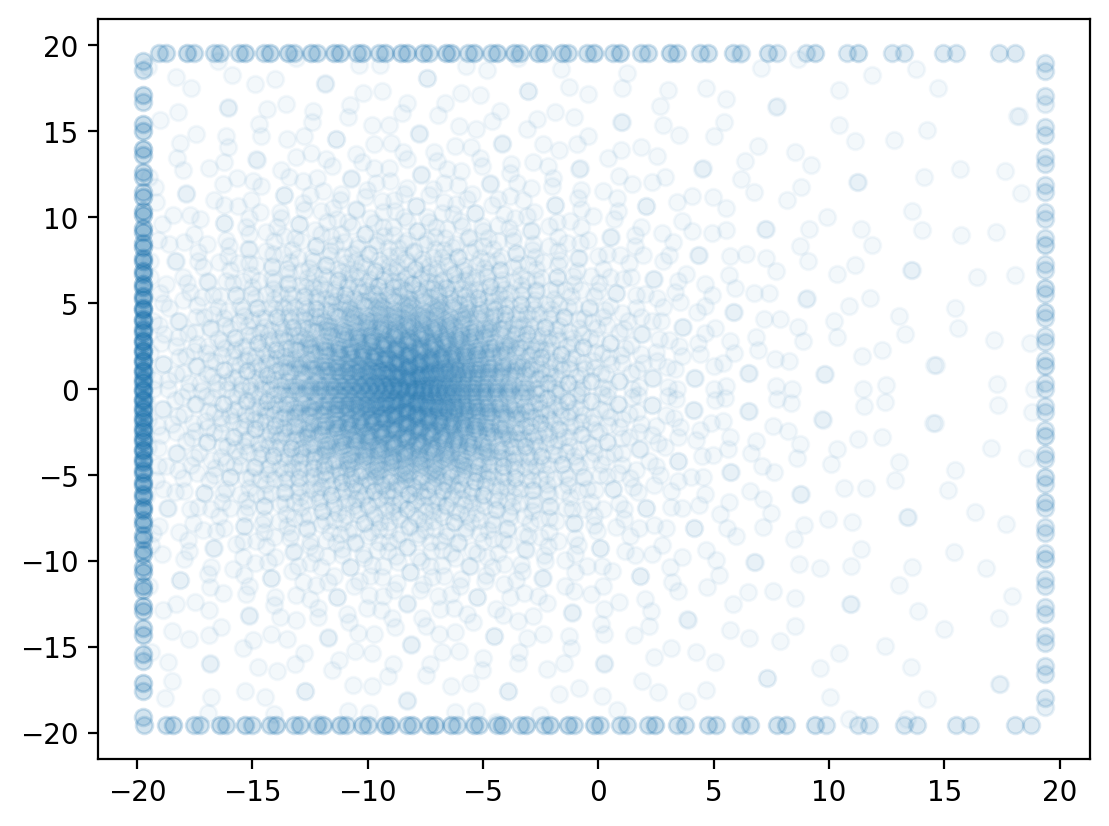

In [3]:
nside = 64
num_int_points = 512
obtain_vmap = jax.vmap(lambda theta,phi:synax.synax.obtain_positions(theta,phi,num_int_points=num_int_points))
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls,nhats = obtain_vmap(theta,phi)
nhats.shape
plt.scatter(poss[::10,0,500],poss[::10,1,500],alpha=0.05)

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    #x = x
    #z = z
    #c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2#*(1-jnp.floor(c))

C_earth = C_page(-8.3,0,0.06)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))
print(4.0e1/C_earth)
C_field = C_page_vmap(poss[:,0,:].reshape(-1),poss[:,1,:].reshape(-1),poss[:,2,:].reshape(-1)).reshape((-1,num_int_points))*4.0e1/C_earth

211.13068378473076


In [5]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [6]:
dtype = np.float64
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
TE_field = tereg
interp_TE_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,TE_field,method='linear',extrap=True))
TE_field_interp = interp_TE_3d(poss)

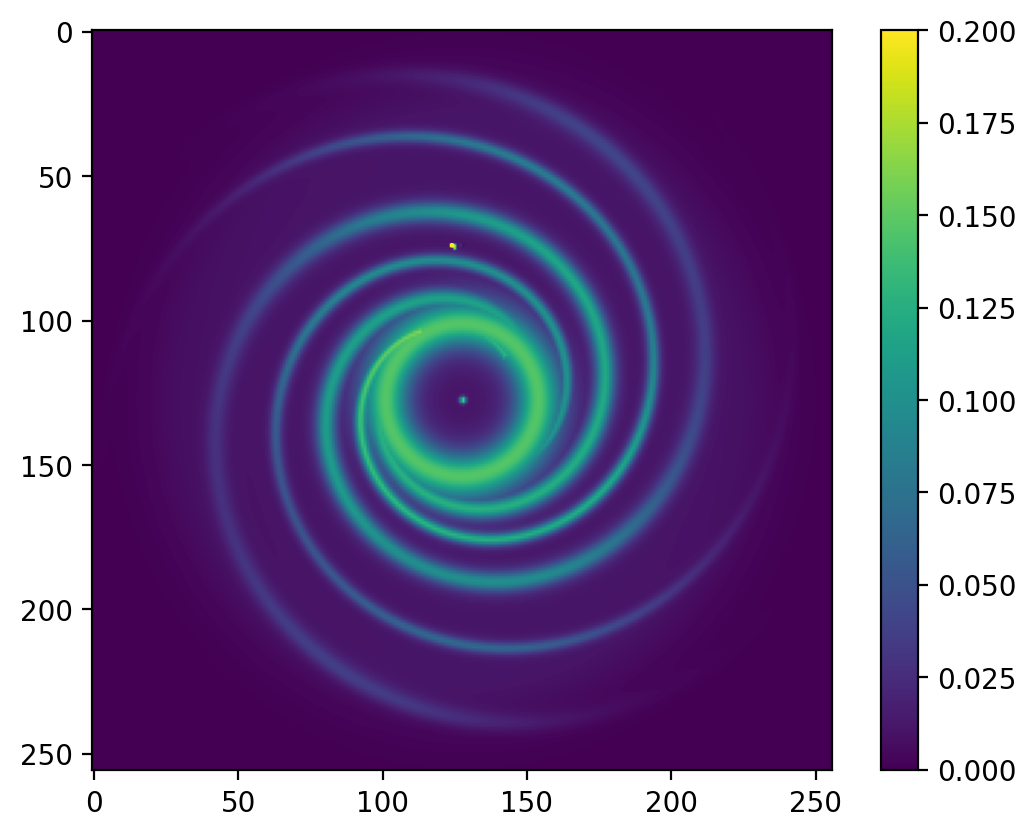

In [7]:
plt.imshow(TE_field[:,:,32],vmax=0.2)
plt.colorbar()

In [8]:
lsa_params = {"b0":5.2,
               "psi0":45.0*np.pi/180,
               "psi1":45*np.pi/180,
               "chi0":45.0*np.pi/180}

B_generator = bfield.B_lsa((poss[:,0,:].reshape(-1),poss[:,1,:].reshape(-1),poss[:,2,:].reshape(-1)))

In [9]:
#const
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

In [10]:
%%time
freq=2.4

B_field = B_generator.B_field(lsa_params).reshape((-1,num_int_points,3))
B_los = -1*((nhats[:,jnp.newaxis,:]*B_field)).sum(axis=-1)
phis = freq_irrelavent_const*TE_field_interp*B_los
sinb = nhats[...,2]
cosb = jnp.sqrt(1-sinb**2)
cosl = nhats[...,0]/cosb
sinl = nhats[...,1]/cosb

Bz = B_field[...,2]
By = B_field[...,1]
Bx = B_field[...,0]
tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
chi0 = jnp.arctan(tanchi0)
phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]

fd = phi_int*const.c**2/(freq**2*1e18)
fd_q = jnp.cos(2*fd+2*chi0)
fd_u = jnp.sin(2*fd+2*chi0)


B_field_square = (B_field**2).sum(axis=-1)

B_trans = (B_field_square-B_los**2)**0.5

emiss = synax.sync_emiss_P(freq,B_trans,C_field,spectral_index=3.)
Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls


CPU times: user 6.27 s, sys: 2.24 s, total: 8.51 s
Wall time: 7.81 s


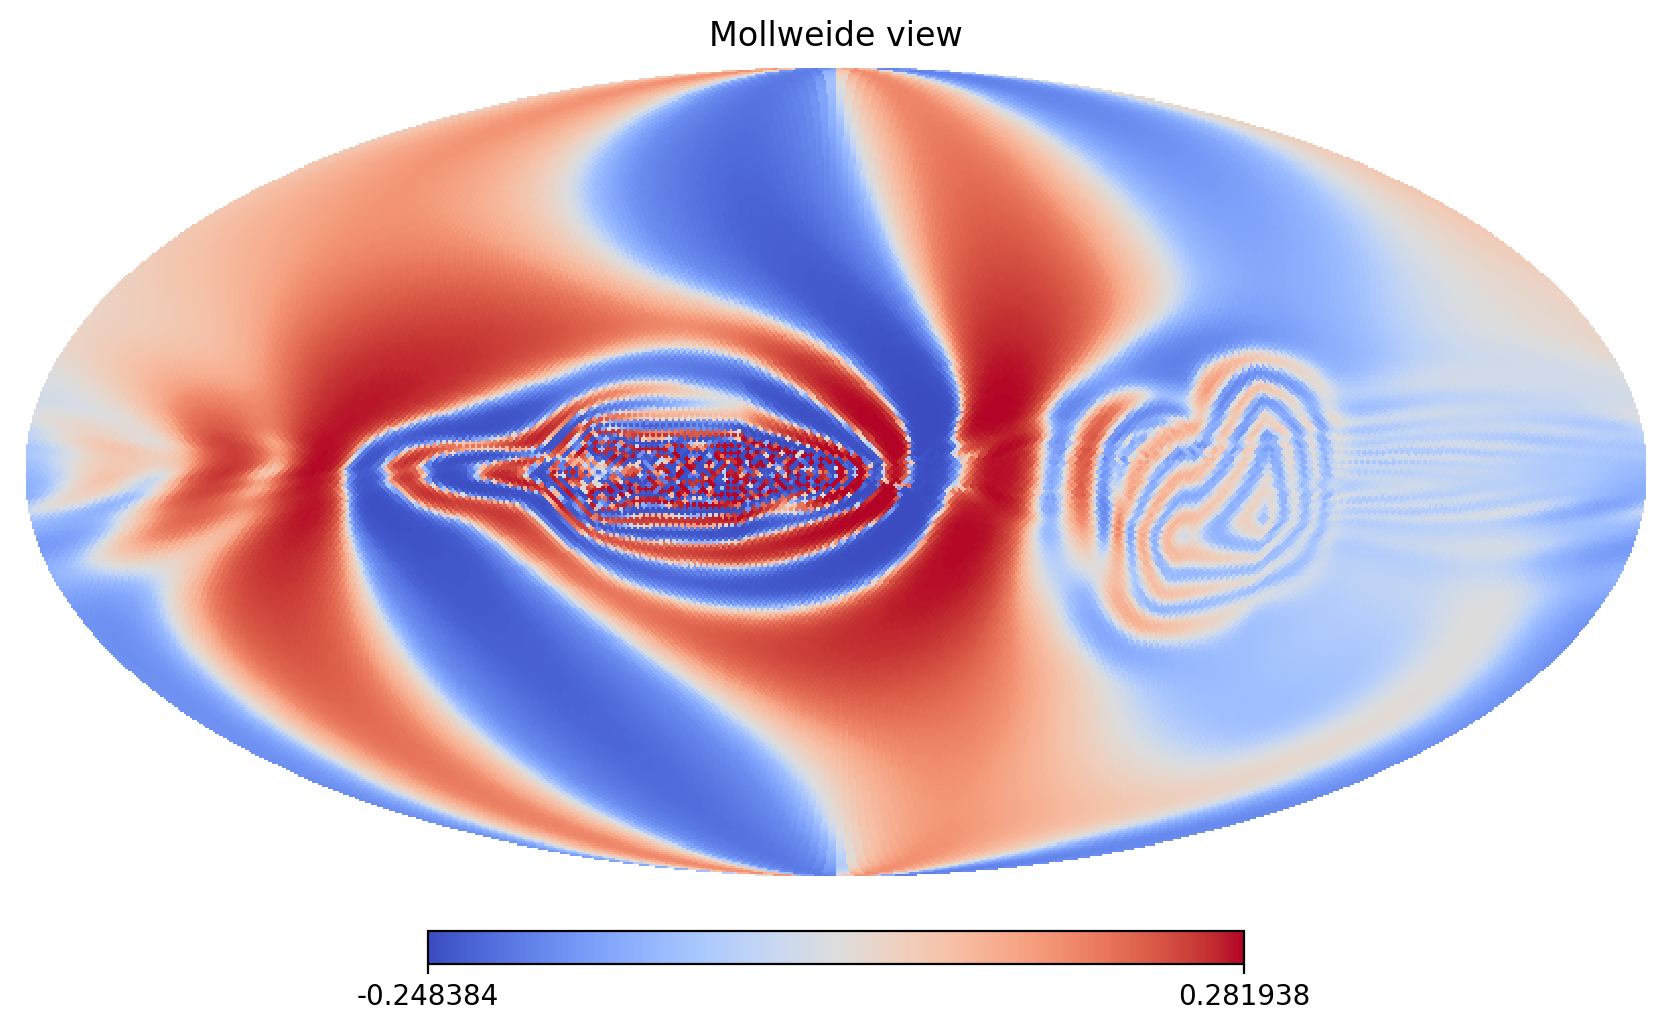

In [11]:
hp.mollview(Sync_Q_int,norm='hist',cmap='coolwarm')

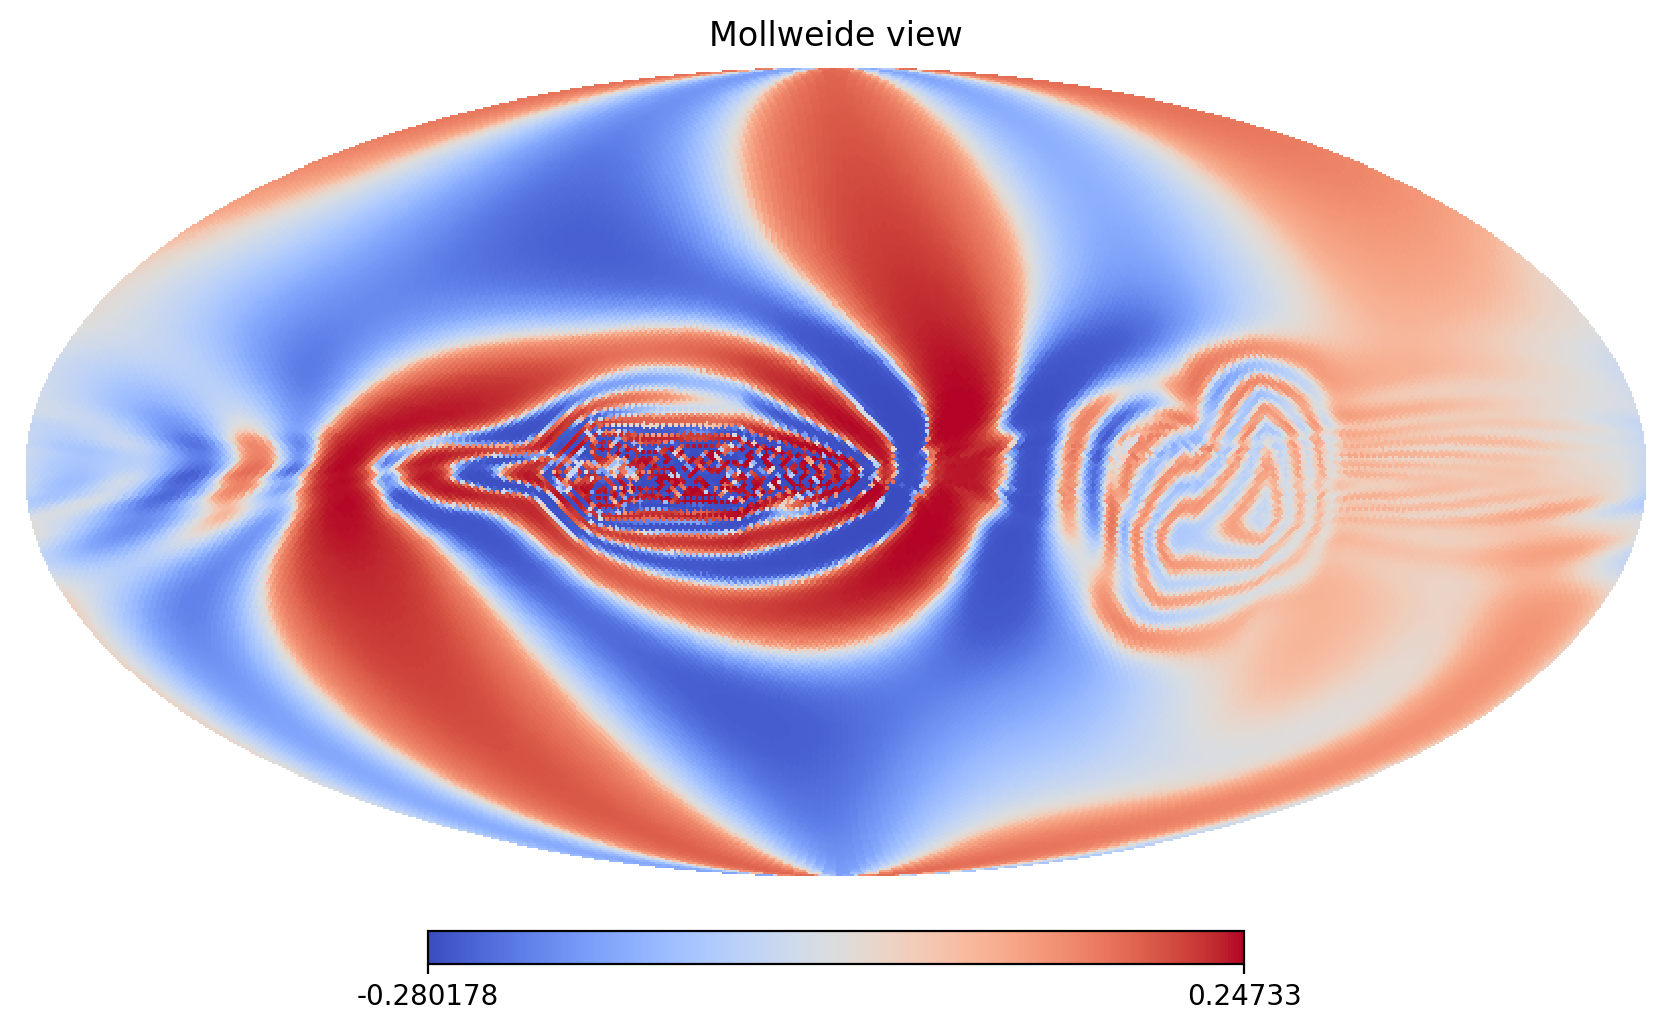

In [12]:
hp.mollview(Sync_U_int,norm='hist',cmap='coolwarm')

## read observation and add noise

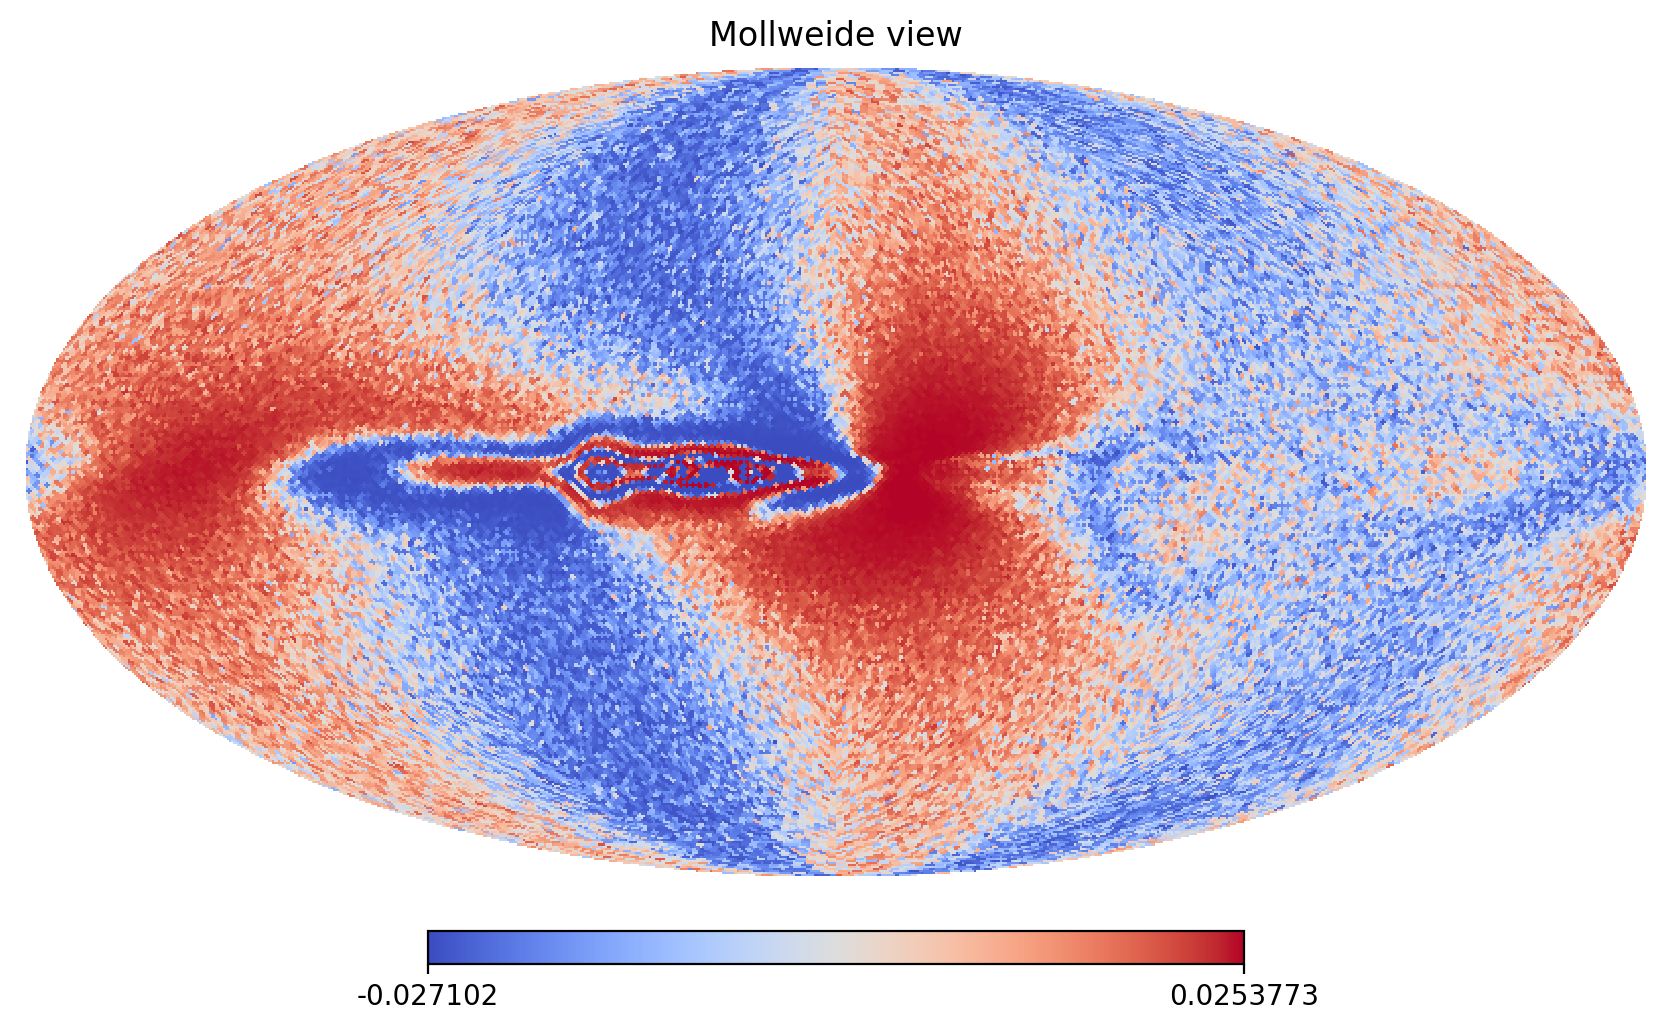

In [13]:
obs_maps = np.load('Sim_lsa.npy')
np.random.seed(42)
obs_Q = obs_maps[0,0] + np.random.randn(obs_maps[0,0].shape[0])*0.001
obs_U = obs_maps[1,0] + np.random.randn(obs_maps[0,0].shape[0])*0.001


hp.mollview(obs_Q,norm='hist',cmap='coolwarm')

In [14]:
from datetime import date
rng_key = jax.random.key(42)

In [15]:
@jax.jit
def lsa_model(lsa_params):
    freq=2.4

    B_field = B_generator.B_field(lsa_params).reshape((-1,num_int_points,3))
    B_los = -1*((nhats[:,jnp.newaxis,:]*B_field)).sum(axis=-1)
    phis = freq_irrelavent_const*TE_field_interp*B_los
    sinb = nhats[...,2]
    cosb = jnp.sqrt(1-sinb**2)
    cosl = nhats[...,0]/cosb
    sinl = nhats[...,1]/cosb

    Bz = B_field[...,2]
    By = B_field[...,1]
    Bx = B_field[...,0]
    tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
    chi0 = jnp.arctan(tanchi0)
    phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]

    fd = phi_int*const.c**2/(freq**2*1e18)
    fd_q = jnp.cos(2*fd+2*chi0)
    fd_u = jnp.sin(2*fd+2*chi0)


    B_field_square = (B_field**2).sum(axis=-1)

    B_trans = (B_field_square-B_los**2)**0.5

    emiss = synax.sync_emiss_P(freq,B_trans,C_field,spectral_index=3.)
    Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
    Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls
    
    return Sync_Q_int,Sync_U_int


def logdensity_fn(lsa_params):
    
    Sync_Q,Sync_U = lsa_model(lsa_params)

    return -1*jnp.sum(((Sync_Q-obs_Q)/0.001/2)**2) - jnp.sum(((Sync_U-obs_U)/0.001/2)**2)

In [16]:
%%time

initial_position = {"b0":1.2,
               "psi0":45.0*np.pi/180,
               "psi1":45*np.pi/180,
               "chi0":45.0*np.pi/180}
logdensity_fn(initial_position)

CPU times: user 8.77 s, sys: 3.55 s, total: 12.3 s
Wall time: 9.9 s


Array(-174349.20721231, dtype=float64)

In [17]:
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity_fn)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
%time (state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=200)

CPU times: user 3min 8s, sys: 8.63 s, total: 3min 17s
Wall time: 3min 12s


In [18]:
state, parameters

(HMCState(position={'b0': Array(1.20052383, dtype=float64, weak_type=True), 'chi0': Array(0.43749783, dtype=float64, weak_type=True), 'psi0': Array(0.47088139, dtype=float64, weak_type=True), 'psi1': Array(0.01816326, dtype=float64, weak_type=True)}, logdensity=Array(-24632.14529044, dtype=float64), logdensity_grad={'b0': Array(-5342.96466592, dtype=float64, weak_type=True), 'chi0': Array(-188.9683437, dtype=float64, weak_type=True), 'psi0': Array(4085.8651892, dtype=float64, weak_type=True), 'psi1': Array(-2662.76362454, dtype=float64, weak_type=True)}),
 {'step_size': Array(0.02821697, dtype=float64, weak_type=True),
  'inverse_mass_matrix': Array([9.10140765e-05, 9.23327695e-05, 9.11082119e-05, 9.29111922e-05],      dtype=float64)})

In [19]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

kernel = blackjax.nuts(logdensity_fn, **parameters).step
%time states = inference_loop(sample_key, kernel, state, 500)

mcmc_samples = states.position

CPU times: user 4min 59s, sys: 4.38 s, total: 5min 3s
Wall time: 5min 1s


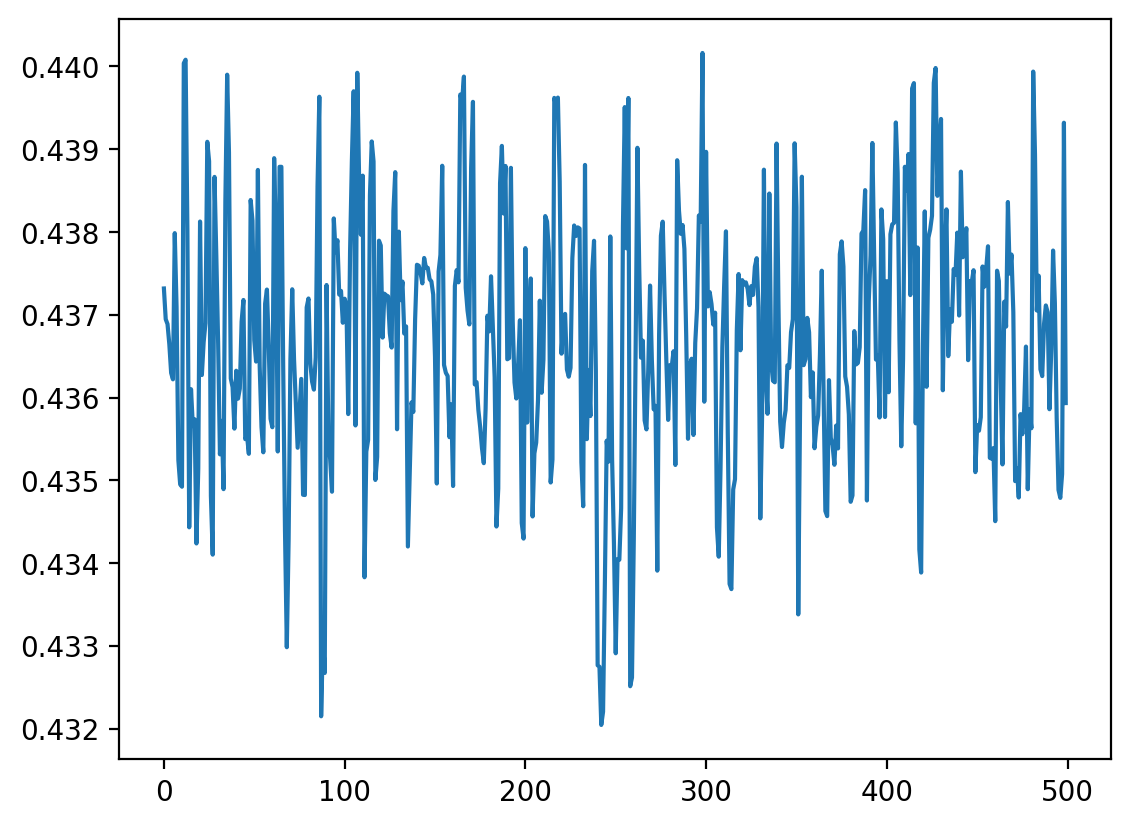

In [20]:
plt.plot(mcmc_samples["chi0"])

In [21]:
from getdist import plots, MCSamples
names = ["b0","psi0","psi1","chi0"]
labels =  [r"b_0",r"\psi_0",r"\psi_1",r"\chi_{0,B}"]
samps = np.array([mcmc_samples[names[i]] for i in range(4)]).T
samples = MCSamples(samples=samps,names = names, labels = labels)


Removed no burn in


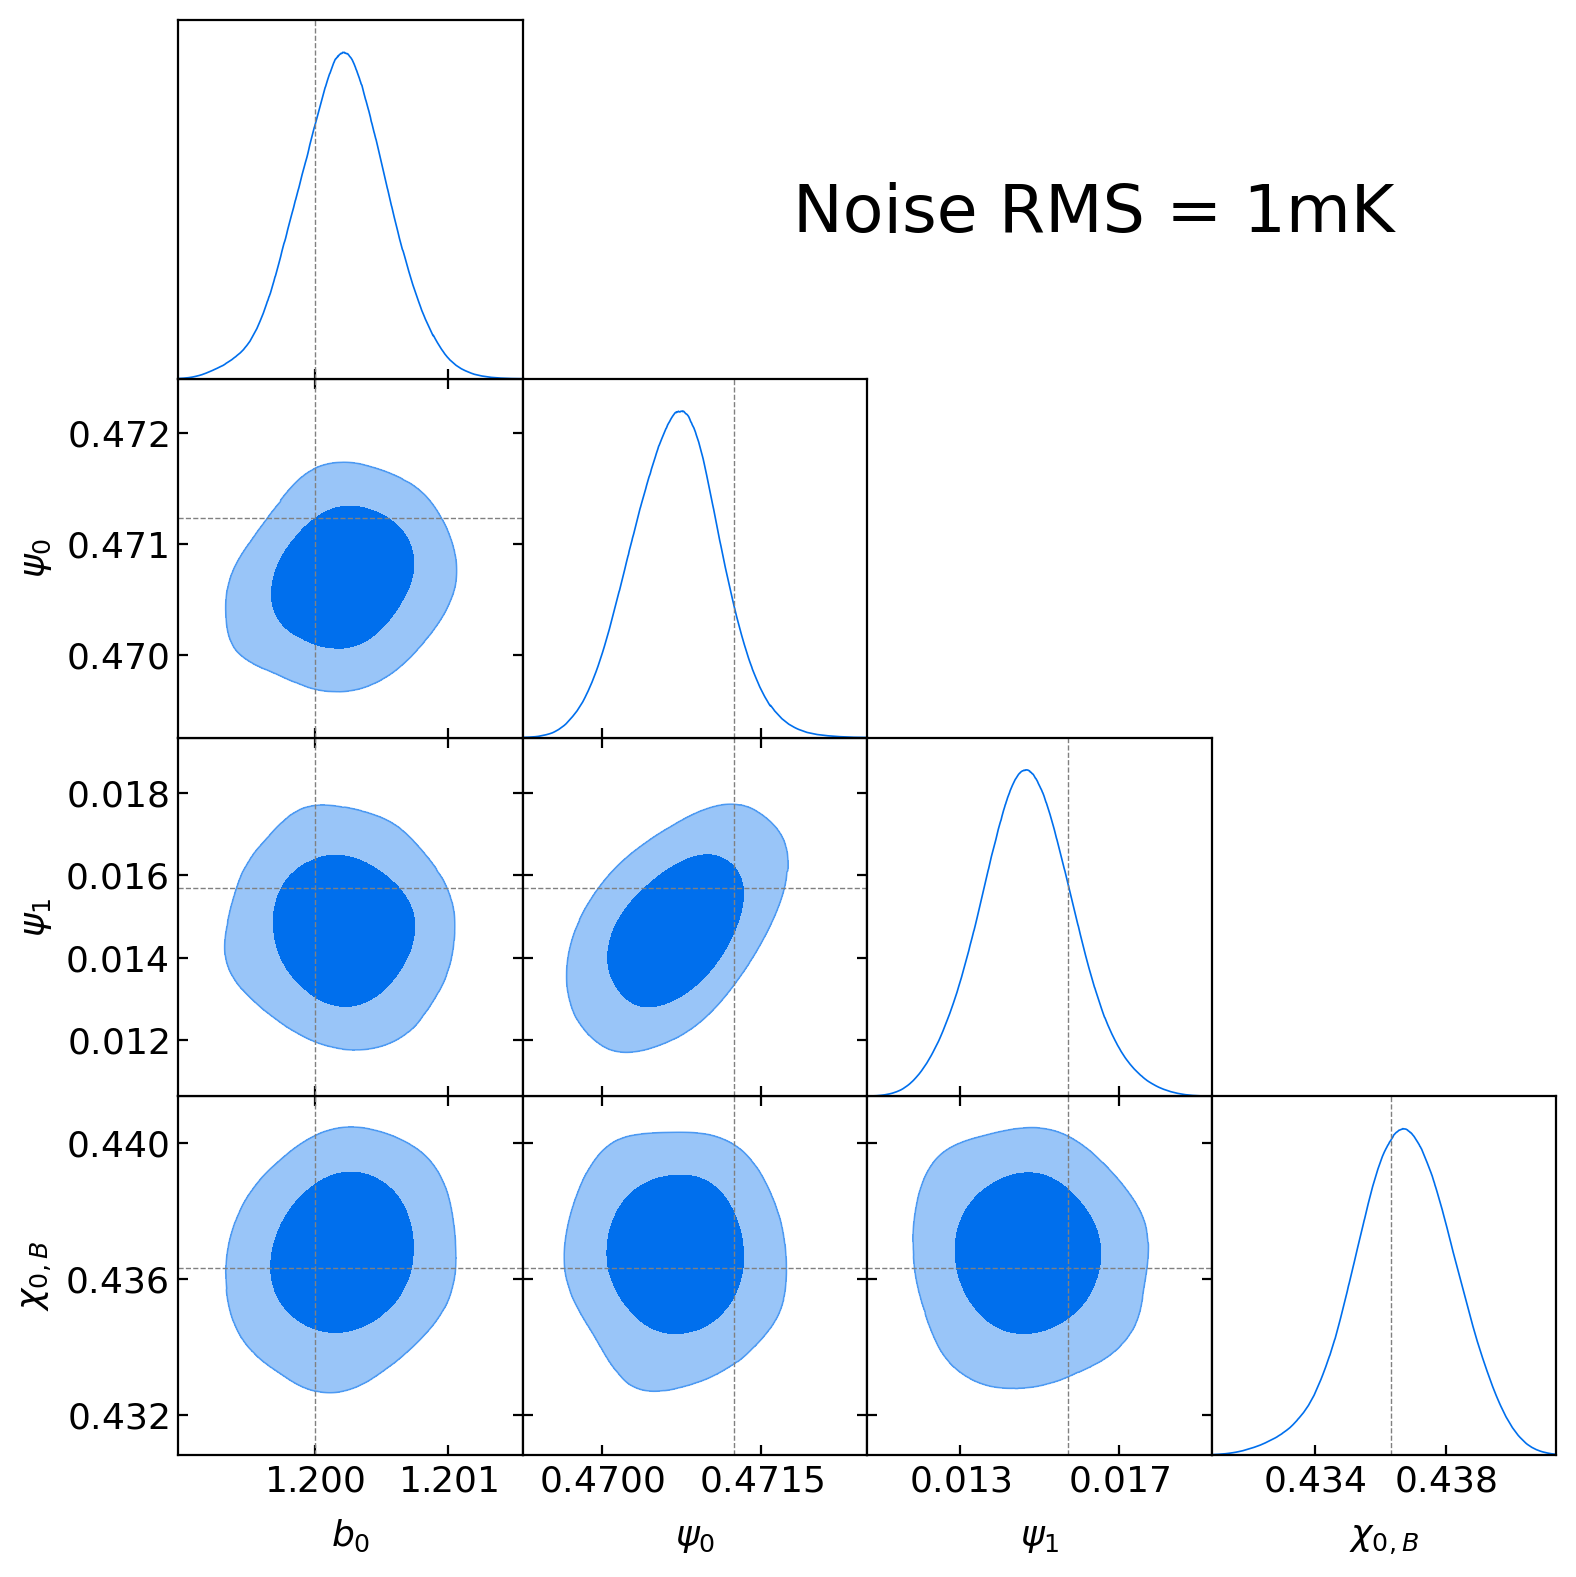

In [22]:
%matplotlib inline

true_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}
g = plots.get_subplot_plotter(rc_sizes=20)
g.settings.lab_fontsize = 16
g.settings.axes_fontsize = 16
g.triangle_plot([samples],names, filled=True,markers=true_params)
plt.suptitle('Noise RMS = 1mK',x=0.88,y=0.88,ha='right',va='top',fontsize = 24)
#plt.suptitle('Noise RMS = 1mK',va = 'bottom',fontsize = 20);
plt.savefig('posterior_lsa_1mk.pdf',dpi=500,bbox_inches='tight')

In [23]:
[blackjax.diagnostics.potential_scale_reduction(samps.T[i].reshape([4,-1])) for i in range(4)]

[Array(1.00263703, dtype=float64),
 Array(1.00255866, dtype=float64),
 Array(0.99908621, dtype=float64),
 Array(1.00567381, dtype=float64)]

In [24]:
[blackjax.diagnostics.effective_sample_size(samps.T[i].reshape([4,-1])) for i in range(4)]

[Array(553.35124266, dtype=float64),
 Array(503.94558124, dtype=float64),
 Array(310.59441063, dtype=float64),
 Array(252.37820164, dtype=float64)]

In [25]:
for name in names:
    acc = np.mean(mcmc_samples[name])/true_params[name]
    print(name+" acc:" + str(1-acc))
    acc = np.mean(mcmc_samples[name])
    print(name+" mean:" + str(acc))
    acc = np.percentile(mcmc_samples[name],[16,84]) - np.mean(mcmc_samples[name])
    print(name+" std:" + str(acc[0])+", "+str(acc[1]))

b0 acc:-0.0001738643826538766
b0 mean:1.2002086372591845
b0 std:-0.0003372701586705773, 0.0003392296976092446
psi0 acc:0.0011506644537284672
psi0 mean:0.4706966601892819
psi0 std:-0.0004436898594020744, 0.0003889098435341798
psi1 acc:0.06484060577279827
psi1 mean:0.014689449414198292
psi1 std:-0.0011748403015462167, 0.001154116877975028
chi0 acc:-0.0008735126447161345
chi0 mean:0.43671345479128487
chi0 std:-0.001444809572399064, 0.0014276393331947301


In [56]:
best_fits = {names[i]:np.mean(mcmc_samples[names[i]]) for i in range(len(names))}

In [57]:
print(logdensity_fn(best_fits))
print(logdensity_fn(true_params))

-64738.70935068895
-3905.418467962747


In [58]:
Sync_Q_best,Sync_U_best = lsa_model(best_fits)
Sync_Q_true,Sync_U_true = lsa_model(true_params)

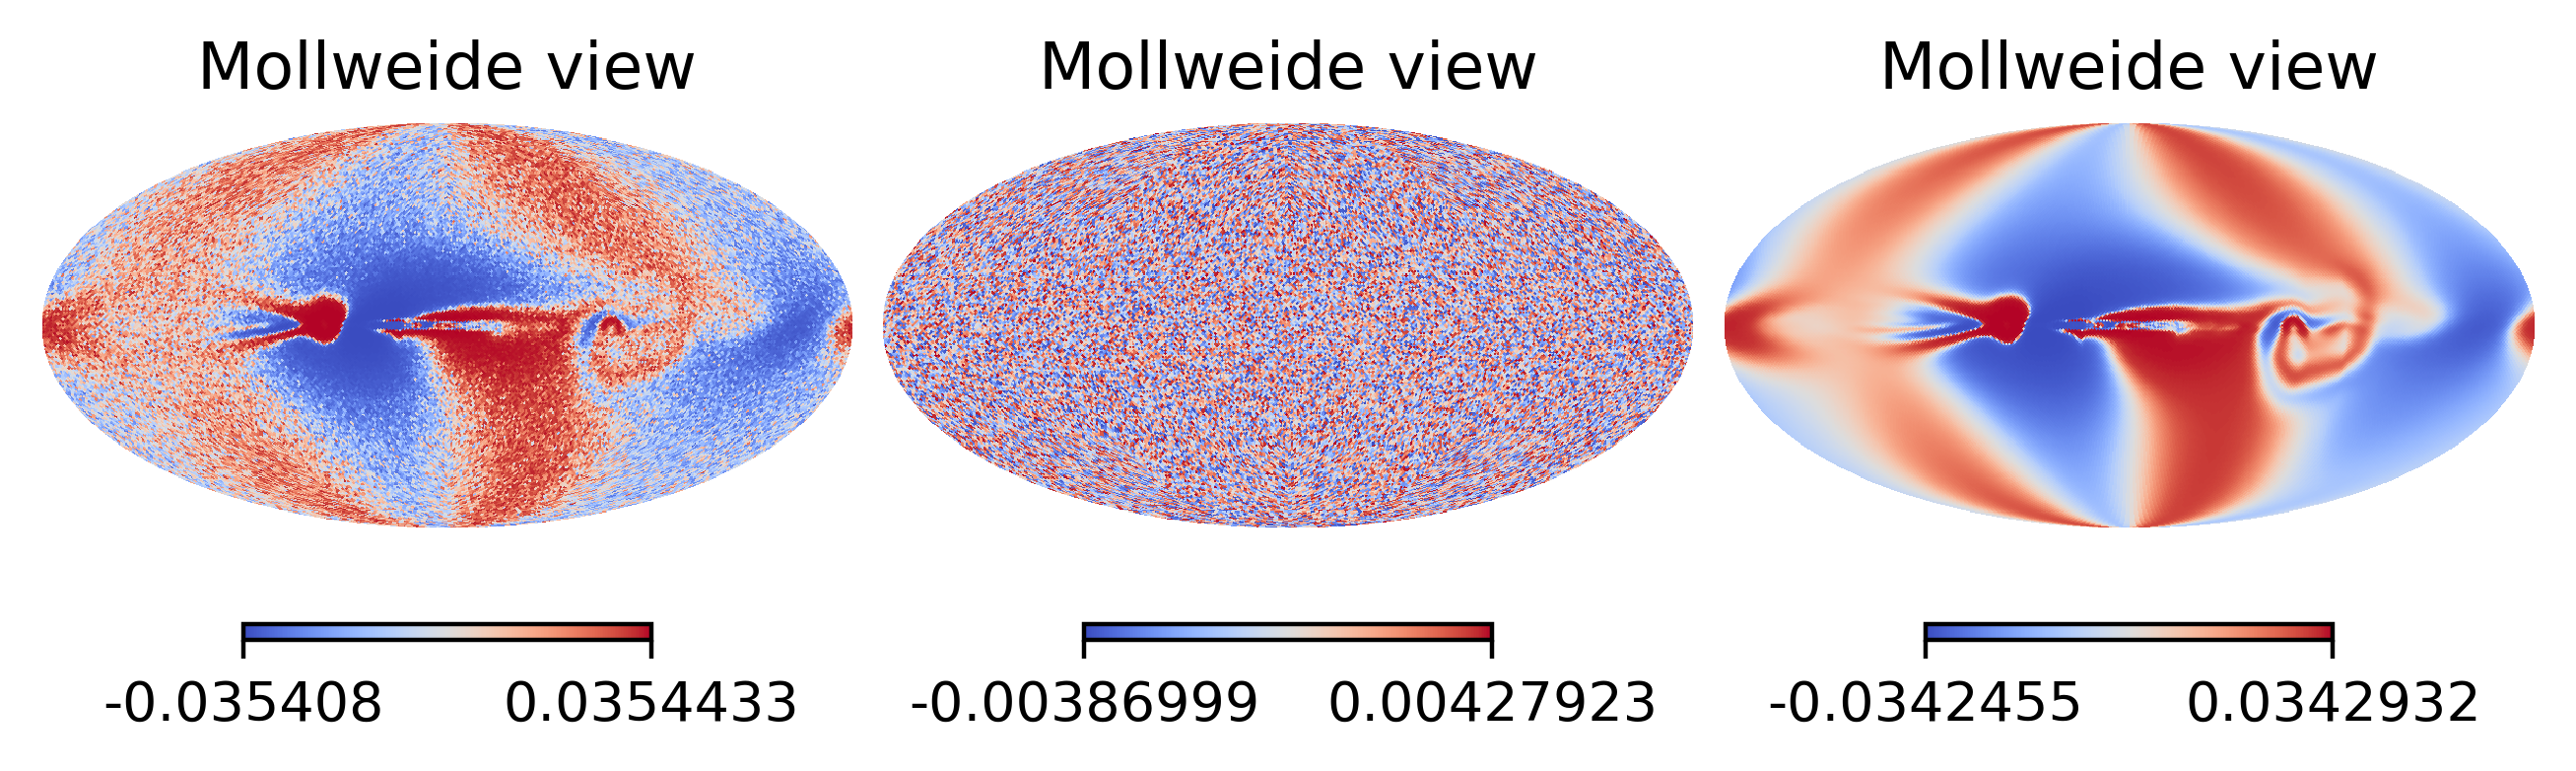

In [59]:
plt.figure(dpi=200)
hp.mollview(Sync_Q_best-obs_Q,norm='hist',cmap='coolwarm',sub=131)
hp.mollview(Sync_Q_true-obs_Q,norm='hist',cmap='coolwarm',sub=132)
hp.mollview(Sync_Q_best-Sync_Q_true,norm='hist',cmap='coolwarm',sub=133)

In [31]:
((Sync_Q_best-obs_Q)**2).sum()

Array(0.04933268, dtype=float64)

In [32]:
((Sync_Q_true-obs_Q)**2).sum()

Array(0.04933838, dtype=float64)